# My First Inverse Kinematic (IK)

In this tutorial we will see how to use some [RBDyn](https://github.com/jorisv/RBDyn) algorithms and some Jacobians to compute the inverse kinematic.

We will not speak about analytic IK that is kind of obsolet. Instead we will focus on gradient based numerical optimization IK.

This tutorial will not be a course on gradient based numerical optimization.
Reader than want to see more on this topic can read [Methodt for non-linear least squares problems](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3215/pdf) for an introduction.
The [Numerical Optimization](http://www.springer.com/fr/book/9780387303031) book is also a great ressource for this topic.

In [1]:
%gui wx
from IPython.display import Image
from tvtk.tools import ivtk
from graph import Axis

# create the viewer
viewer = ivtk.viewer()
viewer.size = (640, 480)

viewer.scene.camera.focal_point = (0.138, 0.958, -0.205)
viewer.scene.camera.position = (3.763, 1.435, 4.453)

display_number = 1
def display():
    global display_number
    path = 'img/SomeAlgorithm/%s.png' % display_number
    display_number += 1
    viewer.scene.save(path)
    return Image(path)

In [2]:
import numpy as np
import eigen3 as e
import spacevecalg as sva
import rbdyn as rbd

from robots import TutorialTree

print 'TutorialTree structure:'
print TutorialTree.__doc__

# create a robot with the same structure than the one in the MultiBody tutorial
mbg, mb, mbc = TutorialTree()

TutorialTree structure:

  Return the MultiBodyGraph, MultiBody and the zeroed MultiBodyConfig with the
  following tree structure:

                b4
             j3 | Spherical
  Root     j0   |   j1     j2     j4
  ---- b0 ---- b1 ---- b2 ----b3 ----b5
  Fixed    RevX   RevY    RevZ   PrismZ
  


In [3]:
# draw the robot
from graph import MultiBodyViz

# add visualization of the of the b4 and b5 body that don't have any successors
X_b4_ef = sva.PTransformd(sva.RotY(-np.pi/2.), e.Vector3d(0.2, 0., 0.))
X_b5_ef = sva.PTransformd(sva.RotX(-np.pi/2.), e.Vector3d(0., 0.2, 0.))
mbv = MultiBodyViz(mbg, mb, endEffectorDict={'b4':(X_b4_ef, 0.1, (1., 1., 0.)),
                                             'b5':(X_b5_ef, 0.1, (1., 1., 0.))})

mbv.addActors(viewer.scene)

## One Task IK

We define a Task by the two following values:
 * $ \mathbf{g}(\mathbf{q}) $: An error
 * $ J_{\mathbf{g}} $: The $ \mathbf{g} $ error Jacobian $ \frac{\partial \mathbf{g}(\mathbf{q})}{\partial \mathbf{q}} $
 
Our objective is to solve the following problem:
$$
\underset{\mathbf{q}}{\text{minimize }} \frac{1}{2} \| \mathbf{g}(\mathbf{q}) \|^2
$$

This is a non-linear least squares problem so we can use a Gauss-Newton like method.

In this method we will compute a descent direction $ \mathbf{\alpha} $ by solving the following problem:
$$
(J_{\mathbf{g}}^T J_{\mathbf{g}}) \mathbf{\alpha} = -J_{\mathbf{g}}^T \mathbf{g}
$$
This problem can be solve by the following least square where $ ^{\#} $ is the pseudoinverse operator:
$$
\mathbf{\alpha} = -J_{\mathbf{g}}^{\#} \mathbf{g}
$$
Then we can integrate $ \mathbf{\alpha} $ to $ \mathbf{q} $ with the following equation $ \mathbf{q}_{k+1} = \mathbf{q}_{k} + \Delta_{st} \mathbf{\alpha}_{k} $ where $ \Delta_{st} $ is the integration step. In this tutorial we will not make any line search and set $ \Delta_{st} = 1 $.

Since the size of $ \mathbf{q} $ and $ \mathbf{\alpha} $ can be different because of some joint we will use the [eulerIntegration alogrithm](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/SomeAlgorithm.ipynb#Euler-Integration) to make this step.

In [4]:
def oneTaskMin(mb, mbc, task, delta=1., maxIter=100, prec=1e-8):
    q = e.toNumpy(rbd.paramToVector(mb, mbc.q))
    iterate = 0
    minimizer = False
    while iterate < maxIter and not minimizer:
        # compute task data
        g = task.g(mb, mbc)
        J = task.J(mb, mbc)
        
        # compute alpha
        alpha = -np.mat(np.linalg.lstsq(J, g)[0])
        
        # integrate and run the forward kinematic
        mbc.alpha = rbd.vectorToDof(mb, e.toEigenX(alpha))
        rbd.eulerIntegration(mb, mbc, delta)
        rbd.forwardKinematics(mb, mbc)
        
        # take the new q vector
        q = e.toNumpy(rbd.paramToVector(mb, mbc.q))
        
        alphaInf = np.linalg.norm(alpha, np.inf)
        yield iterate, q, alpha, alphaInf # yield the current state
        
        # check if the current alpha is a minimizer
        if alphaInf < prec:
            minimizer = True
        iterate += 1

### Body Task

Our first task will allow to target a static frame $ {}^{T} X_{O} $ for a frame $ p $ on a body $ b $ noted $ {}^{p} X_{O} = {}^{p} X_{b} {}^{b} X_{O} $.
The error function will be:
$$
\mathbf{g}^{body} = sva.transformError({}^{T} X_{O}, {}^{p} X_{O})
$$
and the jacobian:
$$
J_{\mathbf{g}^{bdoy}} = \frac{\partial {}^{p} X_{O}(\mathbf{q})}{\partial \mathbf{q}}
$$

In [5]:
class BodyTask(object):
    def __init__(self, mb, bodyId, X_O_T, X_b_p=sva.PTransformd.Identity()):
        self.bodyIndex = mb.bodyIndexById(bodyId)
        self.X_O_T = X_O_T
        self.X_b_p = X_b_p
        self.jac = rbd.Jacobian(mb, bodyId)
        self.jac_mat_sparse = e.MatrixXd(6, mb.nrDof())
            
    def X_O_p(self, mbc):
        X_O_b = list(mbc.bodyPosW)[self.bodyIndex]
        return self.X_b_p*X_O_b
        
    def g(self, mb, mbc):
        X_O_p = self.X_O_p(mbc)
        g_body = sva.transformError(self.X_O_T, X_O_p)
        return e.toNumpy(g_body.vector())
        
    def J(self, mb, mbc):
        X_O_p = self.X_O_p(mbc)
        # set transformation in Origin orientation frame
        X_O_p_O = sva.PTransformd(X_O_p.rotation()).inv()*X_O_p
        jac_mat_dense = self.jac.jacobian(mb, mbc, X_O_p_O)
        self.jac.fullJacobian(mb, jac_mat_dense, self.jac_mat_sparse)
        return e.toNumpy(self.jac_mat_sparse)

### Configuration

We will target a frame $ {}^{T} X_O $ that the TutorialTree robot can reach with the body b5 end effector.

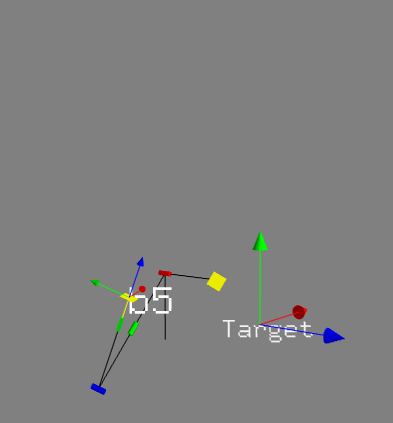

In [6]:
# Set an initial configuration
mbcIK = rbd.MultiBodyConfig(mbc)
quat = e.Quaterniond(np.pi/3., e.Vector3d(0.1, 0.5, 0.3).normalized())
mbcIK.q = [[],
           [3.*np.pi/4.],
           [np.pi/3.],
           [-3.*np.pi/4.],
           [0.],
           [quat.w(), quat.x(), quat.y(), quat.z()]]

rbd.forwardKinematics(mb, mbcIK)
rbd.forwardVelocity(mb, mbcIK) # for motionSubspace

# target frame
X_O_T = sva.PTransformd(sva.RotY(np.pi/2.), e.Vector3d(1.5, 0.5, 1.))

# create the task
bodyTask = BodyTask(mb, mbg.bodyIdByName("b5"), X_O_T, X_b5_ef)

# display initial configuration
from graph import Axis
axis_b5 = Axis(bodyTask.X_O_p(mbcIK), length=0.3, text='b5')
axis_T = Axis(X_O_T, length=0.5, text='Target')
axis_b5.addActors(viewer.scene)
axis_T.addActors(viewer.scene)

mbv.display(mb, mbcIK)
display()

### Result

The result is reached in 7 iterations !

g_body translation error: [[  2.22044605e-16   1.11022302e-16   1.35963107e-32]]
g_body rotation error: [[ -6.12323400e-17   0.00000000e+00  -9.72006753e-18]]


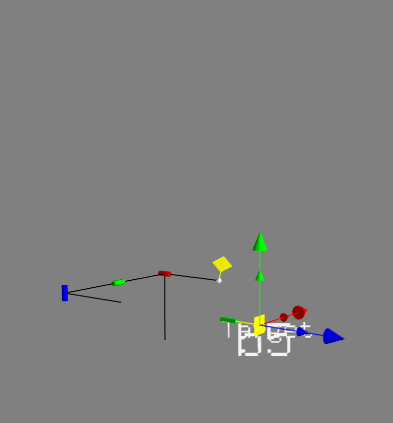

In [7]:
# copy the initial configuration to avoid the algorithm to change it
mbcIKSolve = rbd.MultiBodyConfig(mbcIK)
q_res = None
X_O_p_res = None
alphaInfList = []
for iterate, q, alpha, alphaInf in oneTaskMin(mb, mbcIKSolve, bodyTask, delta=1., maxIter=200, prec=1e-8):
    X_O_p = bodyTask.X_O_p(mbcIKSolve)
    q_res = q
    alphaInfList.append(alphaInf)
    
mbcIKResult = rbd.MultiBodyConfig(mbcIK)
mbcIKResult.q = rbd.vectorToParam(mb, e.toEigenX(q_res))
rbd.forwardKinematics(mb, mbcIKResult)

g_body = bodyTask.g(mb, mbcIKResult)
print 'g_body translation error:', g_body[3:].T
print 'g_body rotation error:', g_body[:3].T

axis_b5.X = X_O_p
mbv.display(mb, mbcIKResult)
display()

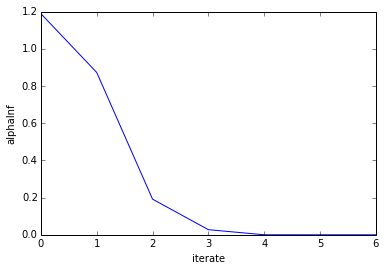

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(alphaInfList)
plt.ylabel('alphaInf')
plt.xlabel('iterate')

## Multy Task IK